## Image Classification

This notebook uses a simple neural network to classify images in Kaggle's MNIST Digit Recognizer data set.  

Image classification is the task of assigning a label or class to an input image. It is a supervised learning problem, where a model is trained on a labeled dataset of images and their corresponding class labels, and then used to predict the class label of new, unseen images.

This notebook 
1. Downloads and reads the Kaggle MNIST training and test datasets, 
2. Builds a basic neural network to classify the training data,
3. Predicts the test data, and 
4. Provides a confusion matrix and accuracy metrics.  

Source: https://www.kaggle.com/competitions/digit-recognizer/overview

### Import Libraries

In [33]:
import os
#!pip install kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 

from sklearn.metrics import classification_report
import seaborn as sn

In [4]:
!mkdir ~/.kaggle
!echo '{"username":"sherylmichael","key":"c75f8d530e0af74d13b7420065cc474b"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mkdir: /Users/sherilyn/.kaggle: File exists


### Download & Read Kaggle date set, MNIST

In [5]:
#download Kaggle data set
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

api = KaggleApi()
api.authenticate()

cls_list=api.competitions_list(search='mnist')
print(cls_list)

[https://www.kaggle.com/competitions/digit-recognizer]


In [6]:
print(api.competition_list_files('digit-recognizer'))
api.competition_download_files('digit-recognizer')

[train.csv, sample_submission.csv, test.csv]


In [45]:
# Read train & test data
zf = ZipFile('/Users/sherilyn/ds_jungle/computer_vision/classification/multiclass/digit_recognizer/data/digit-recognizer.zip')
zf.extractall('/Users/sherilyn/ds_jungle/computer_vision/classification/multiclass/digit_recognizer/data')
zf.close()

In [19]:
train = pd.read_csv(r"/Users/sherilyn/ds_jungle/computer_vision/classification/multiclass/digit_recognizer/data/train.csv")
test = pd.read_csv(r"/Users/sherilyn/ds_jungle/computer_vision/classification/multiclass/digit_recognizer/data/test.csv")

### Exploring Data

#### Explore train data

In [9]:
print("train shape:", train.shape)
train.head()

train shape: (42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
#missing data
train.isna().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

Count of Unique Lables:  10
Unique labels:  [1 0 4 7 3 5 8 9 2 6]


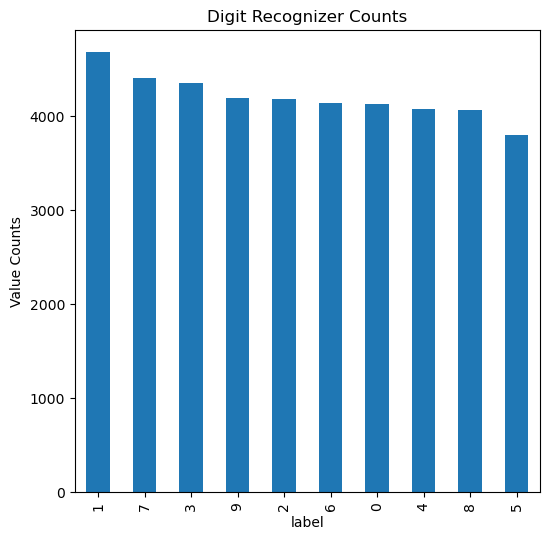

In [11]:
print('Count of Unique Lables: ', train.label.nunique())
print('Unique labels: ', train['label'].unique())

ax = train['label'].value_counts().plot(kind='bar', figsize=(6,6))
fig = ax.get_figure()
ax.set_title("Digit Recognizer Counts")
ax.set_xlabel('label')
ax.set_ylabel('Value Counts');

In [12]:
print("Number of 1: {}".format(len(train[train['label'] == 1])))
print("Number of 5: {}".format(len(train[train['label'] == 5])))

Number of 1: 4684
Number of 5: 3795


Data Summary:

The training data set, train, has 785 columns and 42,000 rows. 
There are no missing data. 
From the data profile on Kaggle, the data set, train, contains gray-scale images of hand-drawn digits, from zero through nine. 
The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image. A value of "0" represents a white image. a value of "1" represents a black image. The data set is relatively balanced for the column, "label"


#### Explore test data

In [13]:
print("test shape:", test.shape)
test.head()

test shape: (28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
#missing data
test.isna().sum()

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64

The test data set, test, has 28000 rows and 784 columns. There are no missing data in test.

Train & test data are categorical. They need to be preprocessed for machine learning models

### Preprocess data

In [20]:
#create target variable, y_train, and feature data, x_train
y_train = train.label
print('y_train.shape: ', y_train.shape)
x_train = train.drop(columns='label')
print('x_train.shape: ', x_train.shape)

y_train.shape:  (42000,)
x_train.shape:  (42000, 784)


In [22]:
#Reshape data to single channel 
#From Kaggle: Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total 
#Normalize pixel values to 0-1 range #From Kaggle: Each pixel-value is an integer between 0 and 255, inclusive.
x_train=x_train.values.reshape(42000,28,28)
x_train=x_train/255
print(x_train.shape)
test=test/255
print(test.shape)

(42000, 28, 28)
(28000, 784)


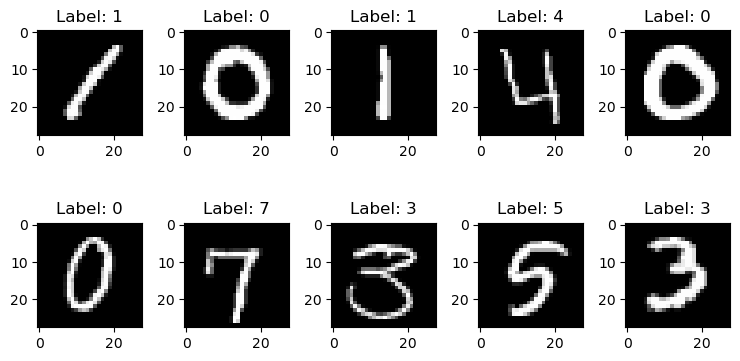

x_train.shape:  (42000, 784)


In [24]:
# see images
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title('Label: {}'.format(y_train[i]))
plt.tight_layout()
plt.show()

x_train=x_train.reshape(42000,28*28)
print('x_train.shape: ', x_train.shape)

x_train, y_train and test are flat files

Kaggle defines data set:
    
"Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total.

#### Train, Val Split

In [25]:
#train, val set split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=1234)
print("x_train shape",x_train.shape)
print("x_val shape",x_val.shape)
print("y_train shape",y_train.shape)
print("y_val shape",y_val.shape)

x_train shape (33600, 784)
x_val shape (8400, 784)
y_train shape (33600,)
y_val shape (8400,)


### Model Building

#### Build a simple neural network having one hidden layer

In [30]:
model = Sequential([
    Dense(784, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
 ])
# compile model
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [35]:
batch=512
numepochs=500
early = EarlyStopping(monitor='val_loss', mode='min', patience=100,restore_best_weights=True, verbose=2)

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train,y_train,validation_split=.2,shuffle=True, epochs=numepochs, 
                       batch_size=batch,callbacks=[early])

Epoch 1/500
53/53 [==============================] - 7s 97ms/step - loss: 0.0045 - accuracy: 0.9987 - val_loss: 0.1432 - val_accuracy: 0.9705
Epoch 2/500
53/53 [==============================] - 6s 114ms/step - loss: 0.0097 - accuracy: 0.9967 - val_loss: 0.1449 - val_accuracy: 0.9696
Epoch 3/500
53/53 [==============================] - 6s 121ms/step - loss: 0.0064 - accuracy: 0.9980 - val_loss: 0.1256 - val_accuracy: 0.9726
Epoch 4/500
53/53 [==============================] - 6s 108ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.1264 - val_accuracy: 0.9735
Epoch 5/500
53/53 [==============================] - 5s 103ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.1213 - val_accuracy: 0.9765
Epoch 6/500
53/53 [==============================] - 6s 104ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 0.1200 - val_accuracy: 0.9763
Epoch 7/500
53/53 [==============================] - 6s 115ms/step - loss: 4.6596e-04 - accuracy: 1.0000 - val_loss: 0.1196 - val_accuracy: 0.9

53/53 [==============================] - 7s 135ms/step - loss: 6.5037e-06 - accuracy: 1.0000 - val_loss: 0.1413 - val_accuracy: 0.9775
Epoch 57/500
53/53 [==============================] - 6s 118ms/step - loss: 6.2995e-06 - accuracy: 1.0000 - val_loss: 0.1415 - val_accuracy: 0.9775
Epoch 58/500
53/53 [==============================] - 6s 110ms/step - loss: 6.0770e-06 - accuracy: 1.0000 - val_loss: 0.1420 - val_accuracy: 0.9766
Epoch 59/500
53/53 [==============================] - 6s 117ms/step - loss: 5.8835e-06 - accuracy: 1.0000 - val_loss: 0.1423 - val_accuracy: 0.9775
Epoch 60/500
53/53 [==============================] - 6s 116ms/step - loss: 5.6573e-06 - accuracy: 1.0000 - val_loss: 0.1427 - val_accuracy: 0.9775
Epoch 61/500
53/53 [==============================] - 6s 117ms/step - loss: 5.4862e-06 - accuracy: 1.0000 - val_loss: 0.1429 - val_accuracy: 0.9772
Epoch 62/500
53/53 [==============================] - 6s 116ms/step - loss: 5.3087e-06 - accuracy: 1.0000 - val_loss: 0.1434 

In [36]:
# evaluate the model
loss, accuracy = model.evaluate(x_val, y_val)
print('Validation model loss:', loss)
print('Validation model accuracy:%.2f' % (accuracy*100))

263/263 [==============================] - 4s 14ms/step - loss: 0.1128 - accuracy: 0.9762
Validation model loss: 0.11277089267969131
Validation model accuracy:97.62


Text(0.5, 1.0, 'Train - Accuracy')

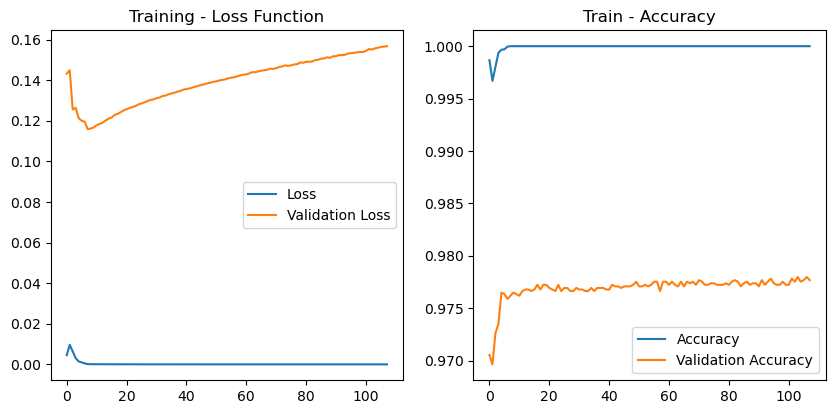

In [37]:
#plot training accuracy vs. loss
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

The increase in the loss function on the validation data suggests that the model is overfitting. It is performing well on the training data but not on new data in the validation set.

In [39]:
# Make the predictions
y_predicted = model.predict(x_val)
# predicted image
np.argmax(y_predicted[0])

263/263 [==============================] - 4s 14ms/step


8

263/263 [==============================] - 3s 9ms/step


Text(33.22222222222222, 0.5, 'Truth')

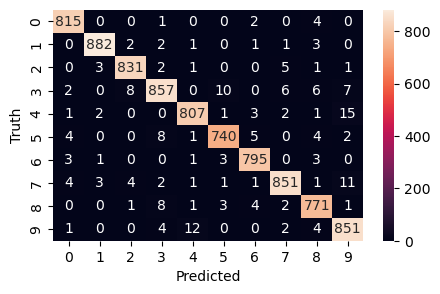

In [40]:
#using a confusion matrix for validation
y_predicted = model.predict(x_val)
y_predicted_labels = [np.argmax(i) for i in y_predicted]

cm = tf.math.confusion_matrix(labels=y_val, predictions=y_predicted_labels)

plt.figure(figsize = (5,3))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

###### The diagonal values in the above confusion matrix are correct predictions.

The black cells show wrong predictions. 

For Example, 8 was correctly predicted as 8 766 times and incorrectly predicted as 5 9 times.

In [41]:
#Predicting on unknown data
new_predictions = model.predict(test)

875/875 [==============================] - 11s 12ms/step


In [42]:
new_predictions.shape

(28000, 10)

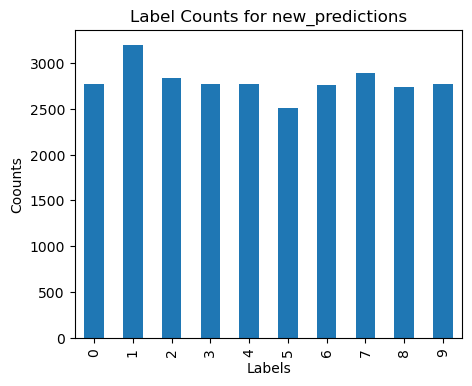

In [43]:
df = pd.DataFrame(new_predictions, columns = ['0','1','2','3','4','5','6','7','8','9'])
df2 = df.sum(axis=0)

# plot new_predictions
df2.plot(x=df2[0], y=df2[1], kind="bar", figsize=(5, 4))
plt.title("Label Counts for new_predictions")
plt.xlabel("Labels")
plt.ylabel("Coounts")
plt.show()